# Evaluating Classification Models

There is an old joke that "economists have predicted 9 of the last 5 recessions." In some sense, this is a commentary on the difficulty of evaluating predictive models. Even if economists predicted all 5 recessions that did happen, they should be penalized for predicting an additional 4 recessions that did not happen. In this section, we will develop the vocabulary to critique predictive models, such as the one mentioned in the joke.

We'll continue using the breast cancer data from the previous notebook.

In [1]:
import pandas as pd

df_breast = pd.read_csv("http://dlsun.github.io/pods/data/breast-cancer.csv")
df_breast.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


How do we measure how good a classification model is? Perhaps the most obvious metric is _accuracy_, which simply measures how often the predicted label matches the actual label. (Remember that the label in a classification model is a _categorical variable_.) Let's train a $10$-nearest neighbors model on the breast cancer data, just so that we have a model to evaluate.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

X_train = df_breast[["Clump Thickness", "Uniformity of Cell Size"]]
y_train = df_breast["Class"]

# define a pipeline
pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=10)
)

pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

Now, we calculate the model's predictions on the training data, and compare to the actual labels in the training data.

In [3]:
y_train_ = pd.Series(pipeline.predict(X_train), name = "Predicted")

pd.crosstab(y_train, y_train_, margins=True)

Predicted,0,1,All
Class,,,
0,426,18,444
1,14,225,239
All,440,243,683


The two-way table above is a called a **confusion matrix**, which can also be computed using scikit-learn.

In [4]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_)


array([[426,  18],
       [ 14, 225]])

The predictions were correct for 426 + 225 = 651 observations out of 683 total, for an accuracy of 651/683 = 0.953, or 95.3%.

There is also a scikit-learn function that calculates the accuracy.

In [5]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_train_)

0.9531478770131772

The accuracy is 95.3%, which sounds impressive. Is it? Consider the hypothetical example represented by the table below. The accuracy here is also 95%. But would you say this is a great model? Also, given this hypothetical training data, can you think of a simple model that achieves even better than 95% accuracy?

|       | Predicted |    0 |   1 |   All |
|-------|----------:|-----:|----:|------:|
| Class |           |      |     |       |
| 0     |           | 9400 | 300 |  9700 |
| 1     |           |  200 | 100 |   300 |
| All   |           | 9600 | 400 | 10000 |

This model does a very poor job at identifying malignant samples:

- out of the 300 malignant samples in the training data, the model only correctly predicted 33% as malignant
- out of the 400 samples predicted to be malignant, only 25% actually were.

Also, in this case, a model which predicts every sample is benign would have 97% training accuracy, but would never correctly predicted malignant samples.

Going back to the real data and model, the accuracy of 95.3% would be less impressive if 95.3% of all samples in the data were benign, since the same accuracy could be achieved by a simple model that predicts that every sample is benign.

The problem with a model that predicts that every sample is benign is that, although the model might be accurate overall, it is very inaccurate for malignant samples. We want a model that is not just accurate overall, but accurate for both benign and malignant samples. There is some ambiguity in how to define "accuracy for malignant samples". As a result, there are two metrics: _precision_ and _recall_.

## Precision and Recall

Suppose we want to calculate the "accuracy" of our model for class $c$. There are two ways to interpret "accuracy for class $c$". Do we want to know the accuracy among the observations our model _predicted to be_ in class $c$ or the accuracy among the observations that _actually were_ in class $c$? The two options lead to two different notions of "accuracy" for class $c$: precision and recall.

The **precision** (a.k.a. positive predictive value) of a model for class $c$ is the proportion of observations predicted to be in class $c$ that actually were in class $c$.

$$ \textrm{precision for class } c = \frac{\text{number of observations in class $c$ that were predicted to be in $c$}}{\text{number of observations predicted to be in class $c$}}. $$

The **recall** (a.k.a. sensitivity) of a model for class $c$ is the proportion of observations actually in class $c$ that were predicted to be in class $c$.

$$ \textrm{recall for class } c = \frac{\text{number of observations in class $c$ that were predicted to be in $c$}}{\text{number of observations in class $c$}}. $$

Another way to think about precision and recall is in terms of true positives (TP) and false positives (FP). A "positive" is an observation that the model identified as belonging to class $c$ (i.e., $\hat y = c$). A true positive is one that actually was in class $c$ (i.e., $\hat y = c$ and $y = c$), while a false positive is one that was not (i.e., $\hat y = c$ and $y \neq c$). True negatives (TN) and false negatives (FN) are defined analogously.

In the language of positives and negatives, the precision is the proportion of positives that are true positives:
$$ \textrm{precision for class } c = \frac{TP}{TP + FP}, $$
The recall is the proportion of observations in class $c$ that are positives (as opposed to negatives):
$$ \textrm{recall for class } c = \frac{TP}{TP + FN}. $$

The figure below may help you to remember which numbers go in the numerator and denominator. The precision is the proportion of the circle that TP makes up, while the recall is the proportion of the red rectangle that TP makes up.

![](https://github.com/dlsun/pods/blob/master/06-Classification-Models/precision_recall.png?raw=1)

Let's calculate the precision and recall of our $10$-nearest neighbors model for benign masses (**Class** = 0). Be sure to carefully note the difference between `y_train` and `y_train_` in the code below.

In [6]:
true_positives = ((y_train_ == 0) & (y_train == 0)).sum()

precision = true_positives / (y_train_ == 0).sum()

recall = true_positives / (y_train == 0).sum()

precision, recall

(0.9681818181818181, 0.9594594594594594)

You can also have scikit-learn calculate the precision and recall. These functions work similarly to `accuracy_score` above, except we have to explicitly specify the class for which we want the precision and recall. For example, to calculate the precision and recall for benign (0) masses:

In [7]:
from sklearn.metrics import precision_score, recall_score

(precision_score(y_train == 0, y_train_ == 0),
 recall_score(y_train == 0, y_train_ == 0))

(0.9681818181818181, 0.9594594594594594)

It is important to specify the class explicitly when calculating the precision and recall. Each class has a different precision and recall. For example, the precision and recall for malignant masses is lower.

In [8]:
true_positives_1 = ((y_train_ == 1) & (y_train == 1)).sum()

precision_1 = true_positives_1 / (y_train_ == 1).sum()
recall_1 = true_positives_1 / (y_train == 1).sum()

precision_1, recall_1

(0.9259259259259259, 0.9414225941422594)

In [9]:
(precision_score(y_train == 1, y_train_ == 1),
 recall_score(y_train == 1, y_train_ == 1))

(0.9259259259259259, 0.9414225941422594)

## Precision-Recall Curves

In general, there is a tradeoff between precision and recall. For example, you can improve recall by casting a wider net, predicting more observations to be in class $c$, but this will hurt precision in general. To take an extreme example, a model that predicts that _every_ observation is in class $c$ necessarily has 100% recall, but its precision will likely be poor. To visualize this phenomenon, suppose we expand the positives from the dashed circle to the solid circle, as shown in the figure on the right below. This increases recall (because the circle now covers more of the red rectangle) but decreases precision (because the red rectangle now makes up a smaller fraction of the circle).

![](https://github.com/dlsun/pods/blob/master/06-Classification-Models/precision_recall_tradeoff.png?raw=1)
*Moving from the dashed circle to the solid circle yields...*

Likewise, we can improve precision by predicting fewer observations to be in class $c$ (i.e., only the ones you are very confident about), but this will hurt recall. This is illustrated in the figure above, at left.

How do we cast a wider (or narrower) net? In many classification models, the predicted label is obtained by first obtaining the predicted probabilities and then choosing the class with the highest probability.

In the case of the breast cancer data set, there are only two classes, so we predict that a breast mass is malignant if the predicted probability of malignancy is $0.5$ or higher. (We predict it is benign otherwise). Instead of using $0.5$ as the threshold, we could cast a wider net for malignancy by lowering the threshold to $0.4$, predicting a breast mass to be malignant as long as the predicted probability is $0.4$ or higher.

In [10]:
probas_ = pipeline.predict_proba(X_train)
probas_

array([[1. , 0. ],
       [0.4, 0.6],
       [1. , 0. ],
       ...,
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ]])

In [11]:
y_train_ = (probas_[:, 1] >= 0.4)

(precision_score(y_train == 1, y_train_ == 1),
 recall_score(y_train == 1, y_train_ == 1))

(0.8888888888888888, 0.9707112970711297)

We see that recall for malignancy increases from 94.1% to 95.8% when we cast this wider net, at the expense of precision, which drops from 92.6% to 90.5%.

It is often instructive to calculate the precision and recall for all possible thresholds and then graph the values as a _precision-recall curve_. Scikit-learn provides a function to calculate the precision and recall for different thresholds.

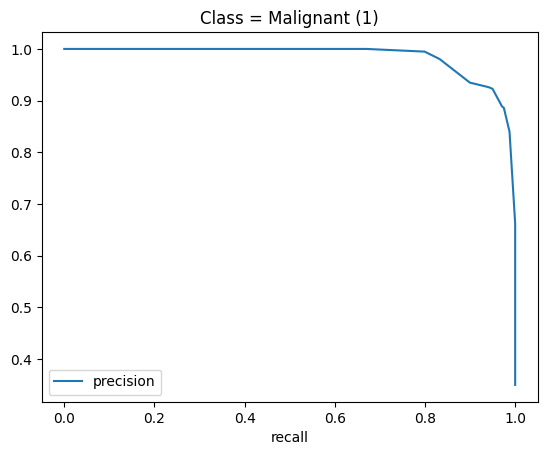

In [12]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(
    y_train == 1, probas_[:, 1]
)

pd.DataFrame({
    "precision": precisions,
    "recall": recalls
}).plot.line(x="recall", y="precision", title="Class = Malignant (1)");

This curve makes the tradeoff between precision and recall explicit. As we lower the threshold, the recall for malignant masses increases from 0% to 100%, while the precision decreases from 100% to about 35%.

We can also plot the precision-recall curve for benign (0) masses.

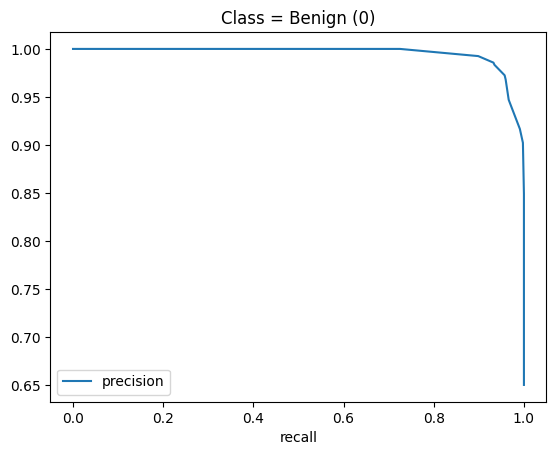

In [13]:
precisions, recalls, thresholds = precision_recall_curve(
    y_train == 0, probas_[:, 0]
)

pd.DataFrame({
    "precision": precisions,
    "recall": recalls
}).plot.line(x="recall", y="precision", title="Class = Benign (0)");

## F1 Score: Combining Precision and Recall

We have replaced accuracy by two numbers: precision and recall. We can combine the precision and recall into a single number, called the **F1 score**.

The F1 score is defined to be the **harmonic mean** of the precision and the recall. That is,

$$ \frac{1}{\text{F1 score}} = \frac{ \frac{1}{\text{precision}} + \frac{1}{\text{recall}}}{2}, $$

or equivalently,

$$ \text{F1 score} = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}. $$

The harmonic mean of two numbers is always between the two numbers, but in general will be closer to the smaller number. For example, if precision is $90\%$ and recall is $10\%$, then the harmonic mean is

$$ \text{F1 score} = \frac{2 \cdot 0.9 \cdot 0.1}{0.9 + 0.1} = 18\%. $$

This is a desirable property of F1 scores because we want to encourage models to have both high precision _and_ high recall. It is not sufficient for one of these to be high if the other is very low. In other words, we do not want a high precision to compensate for a low recall, or vice versa. (This is why we don't just simply take the average of precision and recall.)

The F1 score for benign masses is:

In [14]:
2 * precision * recall / (precision + recall)

0.9638009049773756

We could have also asked Scikit-Learn calculate this for us. If we know the actual and predicted labels, we can use the `f1_score` function, which works similarly to `precision_score` and `recall_score` from above:

In [15]:
from sklearn.metrics import f1_score

# changing the predicted values back to what they were before we changed the threshold
y_train_ = pd.Series(pipeline.predict(X_train), name = "Predicted")

f1_score(y_train == 0, y_train_ == 0)

0.9638009049773756

Likewise, we can compute the F1 score for malignant masses.

In [16]:
2 * precision_1 * recall_1 / (precision_1 + recall_1)

0.9336099585062242

In [17]:
f1_score(y_train == 1, y_train_ == 1)

0.9336099585062242

Accuracy, precision, recall, and F1 score are measures for evaluating classification models. So far we have focused on computing these measures for the *training* data. But just as with regression, we really want to evaluate models based on their *test* scores. We will see how to so this in the next notebook. But consider what we have already seen for regression; what will be different for classification?